In [1]:
import scanpy as sc
import numpy as np
from multigroup_vi.model import MultiGroupVI

import torch
import scvi

scvi.settings.seed = 123

Global seed set to 0
/homes/gws/ewein/micromamba/envs/mgVI/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/homes/gws/ewein/micromamba/envs/mgVI/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
Global seed set to 123


In [2]:
# Please run the `create_haber_region_dataset.ipynb` first to create the AnnData file
adata = sc.read_h5ad("./haber_regional.h5ad")

In [3]:
group_key = "region"
group_indices_list = [np.where(adata.obs[group_key] == group)[0] for group in adata.obs[group_key].unique()]

MultiGroupVI.setup_anndata(adata, layer='count', group_key=group_key)

model = MultiGroupVI(
    adata,
    n_groups=len(adata.obs[group_key].unique()),
    n_shared_latent=10,
    n_private_latent=10,
    wasserstein_penalty=1,
)

model.train(
    group_indices_list,
    max_epochs=500,
    use_gpu=True,
    logger=True,
    early_stopping=False
)

INFO     multigroup_vi: The model has been initialized                                                             


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 2/500:   0%|      | 1/500 [00:01<15:11,  1.83s/it, loss=2.65e+03, v_num=1]

/homes/gws/ewein/micromamba/envs/mgVI/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/homes/gws/ewein/micromamba/envs/mgVI/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 79. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 500/500: 100%|███████| 500/500 [06:49<00:00,  1.22it/s, loss=469, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|███████| 500/500 [06:49<00:00,  1.22it/s, loss=469, v_num=1]


In [4]:
regions = sorted(["Duodenum", "Ileum", "Jejunum"])

In [5]:
adata_regions = {}

for i, region in enumerate(regions):
    tmp_adata = adata[adata.obs[group_key] == region]
    tmp_adata.obsm['X_vae_private'] = model.get_latent_representation(
        adata=tmp_adata,
        representation_kind='private',
        group_number=i
    )

    tmp_adata.obsm['X_vae_shared'] = model.get_latent_representation(
        adata=tmp_adata,
        representation_kind='shared'
    )
    
    adata_regions[region] = tmp_adata


adata_copy = adata.copy()
adata_copy.obsm['X_vae_shared'] = model.get_latent_representation(
    adata=adata_copy,
    representation_kind='shared'
)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [6]:
import seaborn as sns
sns.set()

sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pp.neighbors(adata_copy, use_rep='X_vae_shared')
sc.tl.umap(adata_copy)

for region in regions:
    sc.pp.neighbors(adata_regions[region], use_rep='X_vae_private')
    sc.tl.umap(adata_regions[region])

In [7]:
from scvi.dataloaders import AnnDataLoader
from scvi import REGISTRY_KEYS
from scvi.distributions import ZeroInflatedNegativeBinomial
from scvi.module.base import auto_move_data

@auto_move_data
def log_likelihood(model, adata, indices=None, batch_size=128, variables_to_use="shared"):
    adata = model._validate_anndata(adata)
    data_loader = model._make_data_loader(
        adata=adata,
        indices=indices,
        batch_size=batch_size,
        shuffle=False,
        data_loader_class=AnnDataLoader,
    )
    
    likelihood = torch.zeros(adata.shape[1]).to(model.device)
    for tensors in data_loader:
        x = tensors[REGISTRY_KEYS.X_KEY]
        group_labels = tensors["group"]
                
        inference_outputs = model.module.inference(
            x=x, group_labels=group_labels
        )
        
        z = inference_outputs["qz_m"]
        t_all = inference_outputs["qt_m_all"]
        library = inference_outputs["library"]
        
        generative_outputs = model.module.generative(
            z=z if variables_to_use == "all" or variables_to_use == "shared" else torch.zeros_like(z),
            t_all=t_all if variables_to_use == "all" or variables_to_use == "private" else torch.zeros_like(t_all),
            library=library
        )
        
        px_rate = generative_outputs["px_rate"]
        px_r = generative_outputs["px_r"]
        px_dropout = generative_outputs["px_dropout"]
        
        likelihood_minibatch = (
            ZeroInflatedNegativeBinomial(mu=px_rate, theta=px_r, zi_logits=px_dropout)
            .log_prob(x.to(model.device))
            .sum(axis=0)
        )
        
        likelihood = likelihood + likelihood_minibatch
    return likelihood.detach().cpu().numpy()

def get_likelihood_ratios(adata):
    log_likelihood_shared_only = log_likelihood(model, adata, variables_to_use="shared")
    log_likelihood_all = log_likelihood(model, adata, variables_to_use="all")
    likelihood_ratio = 2*(log_likelihood_all - log_likelihood_shared_only)
    adata.var['likelihood_ratio'] = likelihood_ratio
    return adata

cell_type = "Enterocyte"

adata_all_cell_type = adata[adata.obs['cell_type'] == cell_type].copy()
adata_all_cell_type.X = model.get_normalized_expression(adata_all_cell_type)

adata_all_cell_type_shared = adata_all_cell_type.copy()
adata_all_cell_type_shared.X = model.get_normalized_expression(
    adata_all_cell_type_shared,
    indices_to_return_shared=np.arange(adata_all_cell_type_shared.shape[0])
)

adata_cell_types = {}
adata_cell_types_shared = {}

for region in regions:
    adata_region = adata_regions[region]
    adata_region.X = model.get_normalized_expression(adata_region)
    adata_regions[region] = adata_region
    
    adata_region_cell_type = adata_region[adata_region.obs['cell_type'] == cell_type].copy()
    adata_region_cell_type = get_likelihood_ratios(adata_region_cell_type)
    adata_region_cell_type.X = model.get_normalized_expression(adata_region_cell_type)

    adata_region_cell_type_shared = adata_region_cell_type.copy()
    adata_region_cell_type_shared.X = model.get_normalized_expression(
        adata_region_cell_type,
        indices_to_return_shared=np.arange(adata_region_cell_type_shared.shape[0])
    )
    
    adata_cell_types[region] = adata_region_cell_type
    adata_cell_types_shared[region] = adata_region_cell_type_shared

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/homes/gws/ewein/micromamba/envs/mgVI/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homes/gws/ewein/micromamba/envs/mgVI/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homes/gws/ewein/micromamba/envs/mgVI/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homes/gws/ewein/micromamba/envs/mgVI/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homes/gws/ewein/micromamba/envs/mgVI/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No d

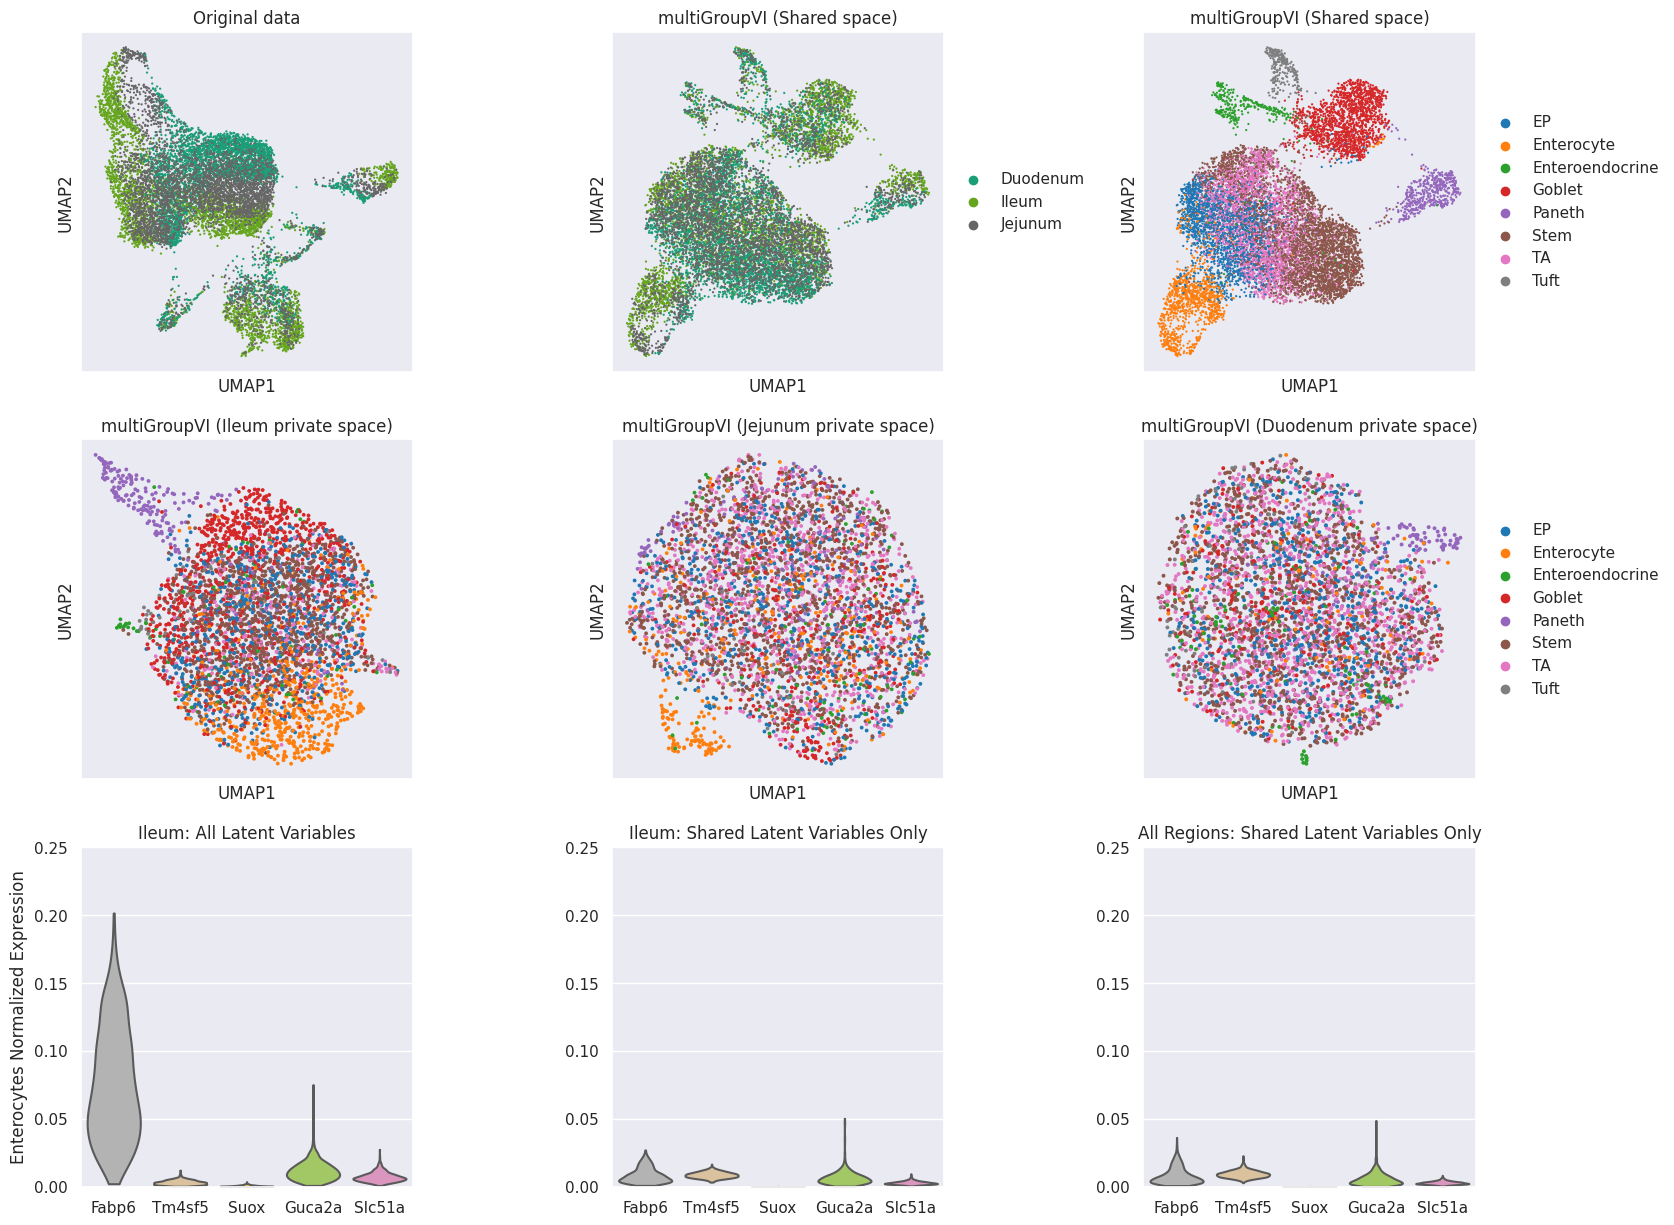

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(18, 15))

region_palette = "Dark2"
sc.pl.umap(adata, color=['region'], wspace=0.25, ax=axes[0][0], show=False, title="Original data",legend_loc=None, palette=region_palette)
sc.pl.umap(adata_copy, color=['region'], wspace=0.25, ax=axes[0][1], show=False, title="multiGroupVI (Shared space)", palette=region_palette)
sc.pl.umap(adata_copy, color=['cell_type'], wspace=0.25, ax=axes[0][2], show=False, title="multiGroupVI (Shared space)")


sc.pl.umap(
    adata_regions["Ileum"],
    color=['cell_type'],
    wspace=0.25,
    ax=axes[1][0],
    show=False,
    legend_loc=None,
    title="multiGroupVI (Ileum private space)"
)

sc.pl.umap(
    adata_regions["Jejunum"],
    color=['cell_type'],
    wspace=0.25,
    ax=axes[1][1],
    show=False,
    legend_loc=None,
    title="multiGroupVI (Jejunum private space)"
)

sc.pl.umap(
    adata_regions["Duodenum"],
    color=['cell_type'],
    wspace=0.25,
    ax=axes[1][2],
    show=False,
    title="multiGroupVI (Duodenum private space)"
)

keys=adata_cell_types['Ileum'].var.sort_values(by='likelihood_ratio', ascending=False).head(5).index

violin_palette = list(reversed(sns.color_palette("Set2")))

sc.pl.violin(
    adata_cell_types['Ileum'],
    keys=keys,
    use_raw=False,
    ax=axes[2][0],
    show=False,
    palette=violin_palette,
    stripplot=False
)
axes[2][0].set_title(f"Ileum: All Latent Variables")
axes[2][0].set_ylim(0, 0.25)
axes[2][0].set_ylabel(f"{cell_type}s Normalized Expression")

sc.pl.violin(
    adata_cell_types_shared['Ileum'],
    keys=keys,
    use_raw=False,
    ax=axes[2][1],
    show=False,
    stripplot=False,
    palette=violin_palette
)
axes[2][1].set_title(f"Ileum: Shared Latent Variables Only")
axes[2][1].set_ylim(0, 0.25)
axes[2][1].set_ylabel("")

sc.pl.violin(
    adata_all_cell_type_shared,
    keys=keys,
    use_raw=False,
    ax=axes[2][2],
    show=False,
    stripplot=False,
    palette=violin_palette
)

axes[2][2].set_title(f"All Regions: Shared Latent Variables Only")
axes[2][2].set_ylim(0, 0.25)
axes[2][2].set_ylabel(f"")

plt.subplots_adjust(wspace=0.6)
plt.show()

/homes/gws/ewein/micromamba/envs/mgVI/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homes/gws/ewein/micromamba/envs/mgVI/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homes/gws/ewein/micromamba/envs/mgVI/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


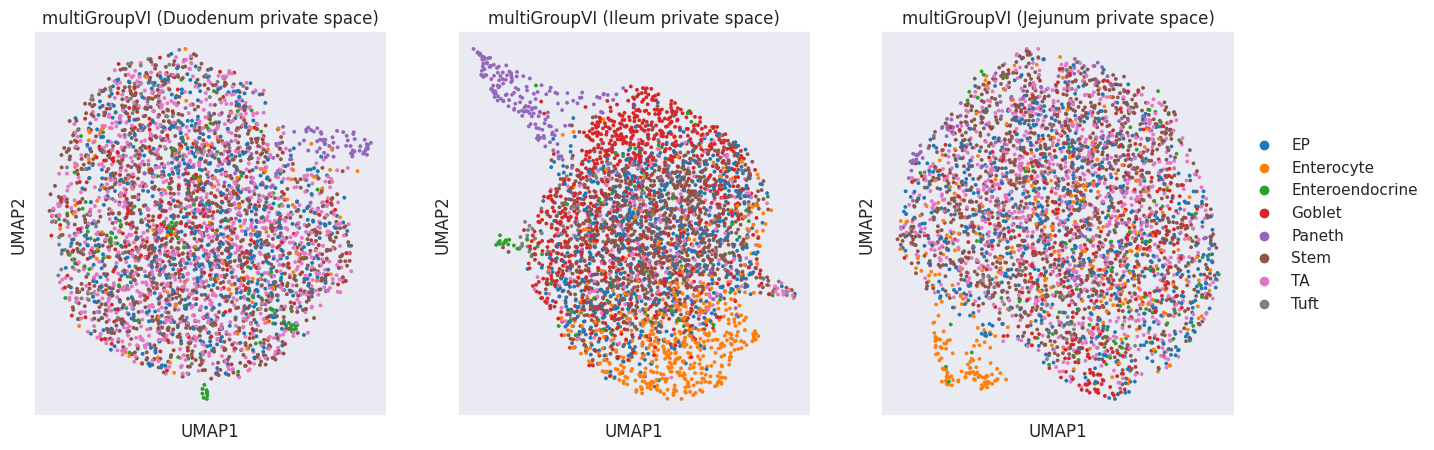

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15.5, 5))

sc.pl.umap(
    adata_regions["Ileum"],
    color=['cell_type'],
    wspace=0.25,
    ax=axes[1],
    show=False,
    legend_loc=None,
    title="multiGroupVI (Ileum private space)"
)

sc.pl.umap(
    adata_regions["Jejunum"],
    color=['cell_type'],
    wspace=0.25,
    ax=axes[2],
    show=False,
    title="multiGroupVI (Jejunum private space)"
)

sc.pl.umap(
    adata_regions["Duodenum"],
    color=['cell_type'],
    wspace=0.25,
    ax=axes[0],
    show=False,
    legend_loc=None,
    title="multiGroupVI (Duodenum private space)"
)

plt.subplots_adjust(wspace=0.2)
plt.show()

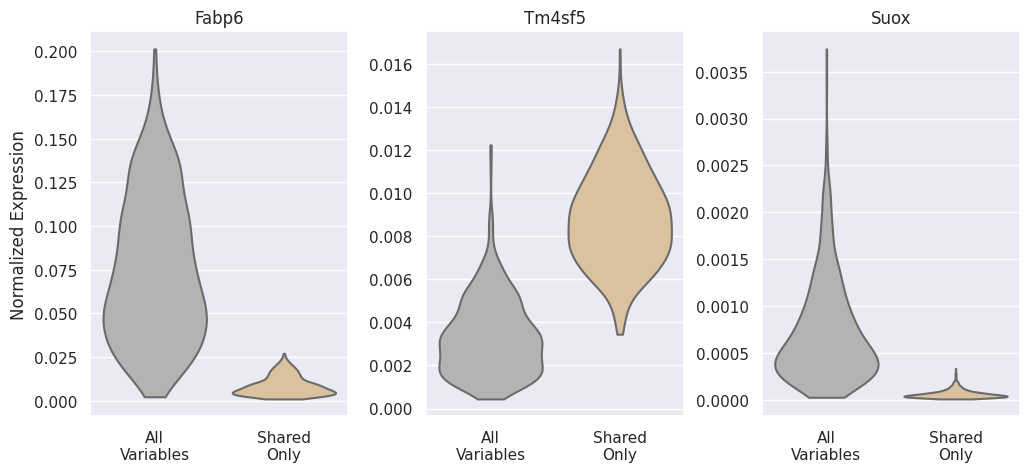

In [12]:
# Big differences in expression for ileum cells

adata_cell_types['Ileum'].obs['which_variables'] = 'All\nVariables'
adata_cell_types_shared['Ileum'].obs['which_variables'] = 'Shared\nOnly'

adata_test = adata_cell_types['Ileum'].concatenate(adata_cell_types_shared['Ileum'])

num_genes = 3

fig, axes = plt.subplots(1, num_genes, figsize=(num_genes*4, 5))
keys = adata_cell_types['Ileum'].var.sort_values(by='likelihood_ratio', ascending=False).head(num_genes).index

for i, gene in enumerate(keys):
    sc.pl.violin(adata_test, keys=keys[i], use_raw=False, stripplot=False, groupby='which_variables', ax=axes[i], show=False, palette=violin_palette)
    axes[i].set_title(keys[i])
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")

axes[0].set_ylabel("Normalized Expression")
plt.subplots_adjust(wspace=0.3)
plt.show()

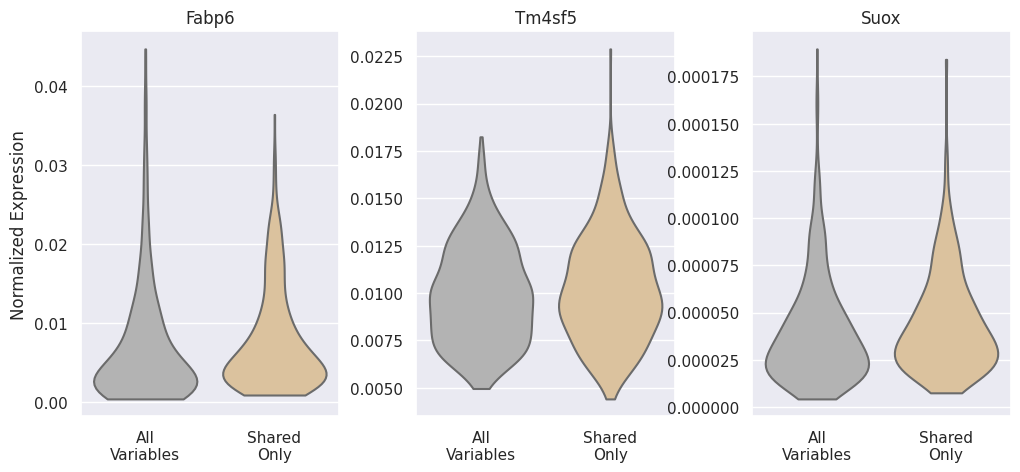

In [14]:
# No major differences in expression for non-ileum cells

adata_cell_type_no_ileum = adata_all_cell_type[adata_all_cell_type.obs['region'] != "Ileum"]
adata_cell_type_no_ileum.obs['which_variables'] = "All\nVariables"

adata_cell_type_shared_no_ileum = adata_all_cell_type_shared[adata_all_cell_type_shared.obs['region'] != "Ileum"]
adata_cell_type_shared_no_ileum.obs['which_variables'] = "Shared\nOnly"


adata_test = adata_cell_type_no_ileum.concatenate(adata_cell_type_shared_no_ileum)

fig, axes = plt.subplots(1, num_genes, figsize=(num_genes*4, 5))
keys = adata_cell_types['Ileum'].var.sort_values(by='likelihood_ratio', ascending=False).head(num_genes).index

for i, gene in enumerate(keys):
    sc.pl.violin(adata_test, keys=keys[i], use_raw=False, stripplot=False, groupby='which_variables', ax=axes[i], show=False, palette=violin_palette)
    axes[i].set_title(keys[i])
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")

axes[0].set_ylabel("Normalized Expression")
plt.subplots_adjust(wspace=0.3)
plt.show()